In [1]:
!pip install transformers


     |████████████████████████████████| 2.1MB 28.0MB/s 
     |████████████████████████████████| 3.3MB 38.4MB/s 
     |████████████████████████████████| 901kB 41.1MB/s 


Mounted at /content/drive


In [43]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score
import random

from transformers import BertTokenizerFast
from tqdm import tqdm
import torch
from torch.utils.data import TensorDataset
import multiprocessing
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
import re
from nltk.stem import PorterStemmer
import nltk

In [44]:
# GPU availability
if torch.cuda.is_available():    
    # use the GPU.    
    device = torch.device("cuda")
    print('GPU(s) available: ',torch.cuda.device_count(), ' GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

GPU(s) available:  1  GPU: Tesla T4


Loading Dataset

In [45]:
# load dataset
qa_df = pd.read_csv('//Extra/train.csv')
qa_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282963 entries, 0 to 282962
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   Unnamed: 0    282963 non-null  int64 
 1   question1     282963 non-null  object
 2   question2     282962 non-null  object
 3   is_duplicate  282963 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 8.6+ MB


In [46]:

def text_clean(text):
    ''' Pre process and convert texts to a list of words '''
    text = str(text)
    text = text.lower()
    stemmer= PorterStemmer()
    lemmatizer = nltk.stem.WordNetLemmatizer()
    w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    return text

In [47]:
nltk.download('wordnet')
qa_df['question1']=qa_df['question1'].apply(lambda x:text_clean(x))
qa_df['question2']=qa_df['question2'].apply(lambda x:text_clean(x))


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [48]:
qa_df.head()

,Unnamed: 0,question1,question2,is_duplicate
0,0,who is the most over rated actress in hindi ci...,who is the most overrated actress in bollywood...,1
1,1,what should every traveler know in order not t...,what should every traveller know in order to n...,0
2,2,how can i name these organic compounds,what are the names of these organic compounds,0
3,3,how many hostels are there in the dayanand sag...,what is the minimum hostel fees in ssn college...,0
4,4,should i read naruto manga or watch the anime,where can you read naruto manga,0


In [49]:
nan_values = qa_df[qa_df.isna().any(axis=1)]
print(nan_values)

Empty DataFrame
Columns: [Unnamed: 0, question1, question2, is_duplicate]
Index: []


In [50]:
# remove NAN rows
qa_df.dropna(inplace=True)
qa_df['is_duplicate'].value_counts(normalize=True)

0    0.631348
1    0.368652
Name: is_duplicate, dtype: float64

In [51]:
# random sample of 5000 rows
qa_sample = qa_df[['question1','question2','is_duplicate']].sample(n=5000, random_state=1)
# checking duplicate question distribution
qa_sample['is_duplicate'].value_counts(normalize=True)

0    0.6298
1    0.3702
Name: is_duplicate, dtype: float64

Splitting Dataset

In [52]:
# stratified splitting for approx similar proportion of duplicate questions through the training and test sets
# train & test set
x_train, x_test, y_train, y_test = train_test_split(qa_sample[['question1','question2']], qa_sample['is_duplicate'], test_size=0.2, random_state=4, stratify=qa_sample['is_duplicate'])

In [53]:
# train & validation dataset
x_train, x_valid, y_train, y_valid = train_test_split(x_train[['question1','question2']], y_train, test_size=0.2, random_state=2)

Tokenizing & Creating Dataloaders for training

In [54]:
# Load pre-trained bert model tokenizer (vocabulary)
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased', do_lower_case=True)

In [55]:
# find maximum length to apply padding
tqdm.pandas()
q1_len = qa_sample["question1"].progress_apply(lambda q1: len(tokenizer.tokenize(q1))) # question1 lengths
q2_len = qa_sample["question2"].progress_apply(lambda q2: len(tokenizer.tokenize(q2))) # question2 lengths
total_len = q1_len + q2_len
max_len = total_len.max()
print("\n\n Maximum Length: ",max_len)

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 5000/5000 [00:00<00:00, 10730.51it/s]



 Maximum Length:  113


In [56]:
# tokenize & convert to tensors
def convert_to_dataset_torch(data: pd.DataFrame, labels: pd.Series) -> TensorDataset:
  input_ids = []
  attention_masks = []
  token_type_ids = []
  for _, row in tqdm(data.iterrows(), total=data.shape[0]):
    # create tokens, add CLS & SEP and encode
    encoded_dict = tokenizer.encode_plus(row["question1"], row["question2"], max_length=max_len, 
                                         padding='max_length', return_attention_mask=True, 
                                         return_tensors='pt', truncation=True)
    # token ids
    input_ids.append(encoded_dict['input_ids'])
    # 
    token_type_ids.append(encoded_dict["token_type_ids"])
    # attention mask - differentiates padding from non-padding
    attention_masks.append(encoded_dict['attention_mask'])
    
  # Convert to  tensors
  input_ids = torch.cat(input_ids, dim=0)
  token_type_ids = torch.cat(token_type_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(labels.values)
  return TensorDataset(input_ids, attention_masks, token_type_ids, labels)

In [57]:
# converting training dataset
train = convert_to_dataset_torch(x_train, y_train)
# converting validation dataset
validation = convert_to_dataset_torch(x_valid, y_valid)

100%|██████████| 800/800 [00:00<00:00, 2738.86it/s]


In [58]:
# batch size for Dataloader
batch_size = 32
core_number = multiprocessing.cpu_count()

# DataLoaders for training set 
train_dataloader = DataLoader(train,  # training samples
                              sampler = RandomSampler(train), # random batches
                              batch_size = batch_size, # batch size
                              num_workers = core_number
                              )

# DataLoaders for validation set
validation_dataloader = DataLoader(validation, # validation samples
                                   sampler = SequentialSampler(validation), # sequential batches 
                                   batch_size = batch_size, # batch size
                                   num_workers = core_number
                                   )

Loading Pre-trained Bert Model

In [59]:
# Load BertForSequenceClassification the pretrained BERT model 
bert_model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # 12-layer BERT model with an uncased vocab
    num_labels=2, # number of output labels   
    output_attentions=False, # Whether the model returns attentions weights
    output_hidden_states=False, # Whether the model returns all hidden-states
)

# run this model on the GPU
bert_model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [60]:
# Optimizer AdamW (class from the huggingface library)
adamw_optimizer = AdamW(bert_model.parameters(),
                  lr = 2e-5, # learning_rate 
                  eps = 1e-8 # adam_epsilon  
                )

# Number of training epochs
epochs = 2

# Total number of training steps 
total_steps = len(train_dataloader) * epochs

# learning rate scheduler
scheduler = get_linear_schedule_with_warmup(adamw_optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

Training the model

In [61]:
# fitting model on training data using dataloader
def fit_batch(dataloader, model, optimizer, epoch):
  total_train_loss = 0
  
  for batch in tqdm(dataloader, desc=f"Training epoch:{epoch}", unit="batch"):
    # Unpack batch from dataloader
    input_ids = batch[0].to(device)
    attention_masks = batch[1].to(device)
    token_type_ids = batch[2].to(device)
    labels = batch[3].to(device)       
    # clear previously calculated gradients before backward pass
    model.zero_grad()
    # forward pass 
    op = model(input_ids, 
                    token_type_ids=token_type_ids, 
                    attention_mask=attention_masks, 
                    labels=labels)
    loss = op[0]
    total_train_loss += loss.item()
    # backward pass to calculate the gradients
    loss.backward()
    # Clip the norm of the gradients to prevent the "exploding gradients" problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    # Update parameters 
    optimizer.step()
    # Update the learning rate
    scheduler.step()
        
  return total_train_loss

In [62]:
# evaluating with validation dataset
def eval_batch(dataloader, model, metric=accuracy_score):
  total_eval_accuracy = 0
  total_eval_loss = 0
  predictions , predicted_labels = [], []
    
  for batch in tqdm(dataloader, desc="Evaluating", unit="batch"):
    # Unpack batch from dataloader
    input_ids = batch[0].to(device)
    attention_masks = batch[1].to(device)
    token_type_ids = batch[2].to(device)
    labels = batch[3].to(device)
        
    # not to bother with constructing the compute graph during the forward pass
    with torch.no_grad():
      # Forward pass
      op = model(input_ids, 
                 token_type_ids=token_type_ids, 
                 attention_mask=attention_masks,
                 labels=labels)
      loss, logits = op[:2]
    
    total_eval_loss += loss.item()
    # accuracy for this batch and accumulate it over all batches
    logits = logits.detach().cpu().numpy()
    label_ids = labels.to('cpu').numpy()
    y_pred = np.argmax(logits, axis=1).flatten()
    total_eval_accuracy += metric(label_ids, y_pred)
    predictions.extend(logits.tolist())
    predicted_labels.extend(y_pred.tolist())
    
  return total_eval_accuracy, total_eval_loss, predictions, predicted_labels

In [63]:
# Set the seed value to make this reproducible.
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)

# training 
def train(train_dataloader, validation_dataloader, model, optimizer, epochs):
    training_stats = []
    
    for epoch in range(0, epochs):        
        # Reset the total loss for epoch
        total_train_loss = 0
        # model into training mode 
        model.train()
        # fitting on training dataset
        total_train_loss = fit_batch(train_dataloader, model, optimizer, epoch)
        # Calculate the average loss over all of the batches
        avg_train_loss = total_train_loss / len(train_dataloader)
        # model in evaluation mode
        model.eval()
        # evaluate on validation dataset
        total_eval_accuracy, total_eval_loss, _, _ = eval_batch(validation_dataloader, model)
        # final accuracy for this validation run
        avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
        print(f"  Accuracy: {avg_val_accuracy}")
        # average loss over all of the batches
        avg_val_loss = total_eval_loss / len(validation_dataloader)
        print(f"  Validation Loss: {avg_val_loss}")
        
        # statistics from this epoch
        training_stats.append(
            {
                'epoch': epoch,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
                'Valid. Accur.': avg_val_accuracy,
            }
        )
        
    print("\nTraining complete!")
    return training_stats

In [64]:
print(bert_model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [65]:
# train
training_stats = train(train_dataloader, validation_dataloader, bert_model, adamw_optimizer, epochs)

Training epoch:1:   0%|          | 0/100 [00:00<?, ?batch/s]

  Accuracy: 0.69125
  Validation Loss: 0.5093021655082702


Evaluating: 100%|██████████| 25/25 [00:05<00:00,  4.27batch/s]

  Accuracy: 0.7425
  Validation Loss: 0.47197970747947693

Training complete!


In [66]:
# training statistics for each epoch
train_stats = pd.DataFrame(training_stats).set_index('epoch')
train_stats

,Training Loss,Valid. Loss,Valid. Accur.
epoch,,,
0,0.553143,0.509302,0.69125
1,0.414490,0.471980,0.74250


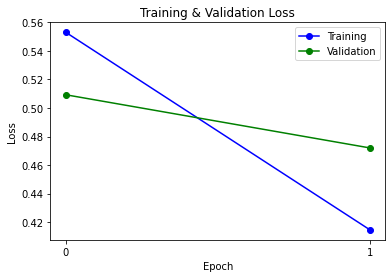

In [67]:
# visualizing training & validation loss
from matplotlib import pyplot as plt
%matplotlib inline

plt.plot(train_stats['Training Loss'], 'b-o', label="Training")
plt.plot(train_stats['Valid. Loss'], 'g-o', label="Validation")
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks(train_stats.index.values.tolist())
plt.show()

Performance on Test Dataset

In [68]:
# test dataset
test = convert_to_dataset_torch(x_test, y_test)
# test set dataloader
test_dataloader = DataLoader(test, sampler=SequentialSampler(test), batch_size=batch_size)

100%|██████████| 1000/1000 [00:00<00:00, 2688.21it/s]


In [69]:
bert_model.eval()
# predict labels for test set
_, _,_ ,predicted_labels = eval_batch(test_dataloader, bert_model)

Evaluating: 100%|██████████| 32/32 [00:07<00:00,  4.53batch/s]


In [70]:
# testing performance
dt = {'y_Actual': y_test,
      'y_Predicted': predicted_labels
      }
df = pd.DataFrame(dt, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)

Predicted    0    1
Actual             
0          412  218
1           41  329


In [71]:
# save model
from pathlib import Path

output_dir = Path("__file__").parents[0].absolute().joinpath("model_save")
output_dir.mkdir(exist_ok=True)
# Save a trained model, configuration and tokenizer 
model_to_save = bert_model.module if hasattr(bert_model, 'module') else bert_model  
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(str(output_dir.absolute()))

('/content/model_save/tokenizer_config.json',
 '/content/model_save/special_tokens_map.json',
 '/content/model_save/vocab.txt',
 '/content/model_save/added_tokens.json')

In [74]:
def QuestionQuestionChecking():
    q1 = text_clean(input("Enter the Question 1 : "))
    q2 = text_clean(input("Enter the Question 2 : "))
    encoded_dict = tokenizer.encode_plus(q1, q2, max_length=max_len, 
                                         padding='max_length', return_attention_mask=True, 
                                         return_tensors='pt', truncation=True)
    bert_model.eval()
    input_ids = encoded_dict['input_ids'].to(device)
    attention_masks = encoded_dict['attention_mask'].to(device)
    token_type_ids = encoded_dict['token_type_ids'].to(device)
    op = bert_model(input_ids, 
                 token_type_ids=token_type_ids, 
                 attention_mask=attention_masks)
    logits = op[0]
    logits = logits.detach().cpu().numpy()
    y_pred = np.argmax(logits)
    if y_pred == 1:
        print("The questions are duplicate")
    else:
        print("The questions are different")
    decision = input("Do you want to continue [Y/N]?")
    if decision.strip() == 'N':
        print("Ok bye")
    else:
        QuestionQuestionChecking()

In [75]:
QuestionQuestionChecking()

Enter the Question 1 : How to learn python ?
Enter the Question 2 : what is the best way to learn python ?
The questions are duplicate
Do you want to continue [Y/N]?Y
Enter the Question 1 : What is a bitcoin ? 
Enter the Question 2 : explain Radiation ?
The questions are different
Do you want to continue [Y/N]?N
Ok bye
